# Autoencoders and Fraud Detection


![](https://traderdefenseadvisory.com/wp-content/uploads/2020/12/financial_protection_credit_card_fraud_img1.jpg)

**Imports**

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split 

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

import xgboost as xgb

plt.style.use('seaborn')

## Data

>The [datasets](https://www.kaggle.com/mlg-ulb/creditcardfraud) contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

>It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
df = pd.read_csv('data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## EDA

**Feature Correlation**

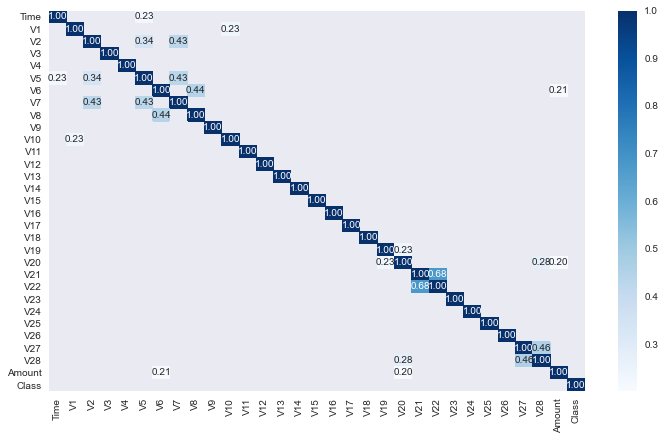

In [3]:
corr = df.corr(method='spearman')
plt.figure(figsize=(12,7))
sns.heatmap(corr[corr > .2],annot=True,fmt='.2f',cmap='Blues');

# Modeling

**Select Features for modeling**

In [4]:
features = ['Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
target = 'Class'

**Train Test Split**

In [5]:
train, test = train_test_split(df, test_size=0.33,random_state=42,stratify=df[target])

# Autoencoder

![](https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png)

Autoencoder is a neural network designed to learn an identity function in an unsupervised way to reconstruct the original input while compressing the data in the process so as to discover a more efficient and compressed representation. 

The encoder network essentially accomplishes the dimensionality reduction, just like how we would use Principal Component Analysis (PCA) or Matrix Factorization (MF) for. In addition, the autoencoder is explicitly optimized for the data reconstruction from the code. A good intermediate representation not only can capture latent variables, but also benefits a full decompression process.

**Define a generalistic Auto Encoder**

In [6]:
def autoencoder(shape,regularizer=regularizers.l1(10e-5)):
    ## input layer X_train.shape[1]
    input_layer = Input(shape=(shape,))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizer)(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(shape, activation='relu')(decoded)
    
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    return autoencoder

Pass the shape of your X_train

In [7]:
encoder = autoencoder(train[features].shape[1])

**Keras model Summary**

In [8]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________

**Let's normalize our data**

In [9]:
scaler = preprocessing.MinMaxScaler().fit(train[features].values)

In [10]:
scaled_data = df.copy()
scaled_data[features] = scaler.transform(df[features])

fraud, non_fraud = scaled_data.loc[scaled_data[target] == 1],scaled_data.loc[scaled_data[target] == 0]

**Now we can fit our Autoencoder**

In [11]:
encoder.fit(scaled_data[features], scaled_data[features], epochs = 20, shuffle = True, validation_split = 0.25)

Epoch 1/20
6676/6676 [==============================] - 9s 1ms/step - loss: 0.1457 - val_loss: 0.0821
Epoch 2/20
6676/6676 [==============================] - 6s 845us/step - loss: 0.0772 - val_loss: 0.0821
Epoch 3/20
6676/6676 [==============================] - 6s 867us/step - loss: 0.0770 - val_loss: 0.0818
Epoch 4/20
6676/6676 [==============================] - 5s 790us/step - loss: 0.0769 - val_loss: 0.0814
Epoch 5/20
6676/6676 [==============================] - 7s 976us/step - loss: 0.0768 - val_loss: 0.0810
Epoch 6/20
6676/6676 [==============================] - 5s 783us/step - loss: 0.0712 - val_loss: 0.0603
Epoch 7/20
6676/6676 [==============================] - 5s 722us/step - loss: 0.0559 - val_loss: 0.0599
Epoch 8/20
6676/6676 [==============================] - 5s 717us/step - loss: 0.0558 - val_loss: 0.0596
Epoch 9/20
6676/6676 [==============================] - 5s 713us/step - loss: 0.0557 - val_loss: 0.0593
Epoch 10/20
6676/6676 [==============================] - 5s 710us/

We extract the hidden layers so then our model can encode given data

In [12]:
hidden_representation = Sequential()
hidden_representation.add(encoder.layers[0])
hidden_representation.add(encoder.layers[1])
hidden_representation.add(encoder.layers[2])

then we encode the two dataframes that contains fraudulent and non fraudulent samples

In [13]:
fraud_hidden = hidden_representation.predict(fraud[features])
non_fraud_hidden = hidden_representation.predict(non_fraud[features])

finally we ca bring them back together into a dataframe where we can see that we have a higher number of features than the initial one, this being a result of our 3rd layer which has an output shape of 50 

In [14]:
encoded_df = pd.DataFrame(np.append(fraud_hidden, non_fraud_hidden, axis = 0))
encoded_df[target] = np.append(np.ones(fraud_hidden.shape[0]), np.zeros(non_fraud_hidden.shape[0]))
encoded_df[target] = encoded_df[target].astype(int)
encoded_df[:3]

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Class
0,0.0,0.176606,0.482658,0.149698,0.0,0.0,0.675127,0.0,0.677855,0.018553,...,0.257808,0.0,0.070143,0.015373,0.0,0.0,0.0,0.0,0.153822,1
1,0.0,0.141019,0.480566,0.048828,0.0,0.0,0.617751,0.0,0.668253,0.000000,...,0.260265,0.0,0.094272,0.000000,0.0,0.0,0.0,0.0,0.217649,1
2,0.0,0.151974,0.425213,0.094413,0.0,0.0,0.695415,0.0,0.605650,0.000000,...,0.183696,0.0,0.106665,0.000000,0.0,0.0,0.0,0.0,0.159188,1


# Classification models

Now that we have encoded data we wan to train an XGBoost model to classify fraudulent accounts.

We will use first the raw data to train the classifier, then in the second part we will use the encoded data.

**Before Autoencoding**

train the classifier

In [15]:
%%time
clf = xgb.XGBClassifier(objective='binary:logistic',use_label_encoder=False,eval_metric='logloss')
clf.fit(train[features],train[target])

CPU times: user 2min 49s, sys: 896 ms, total: 2min 50s
Wall time: 23.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

make predictions on the test data

In [16]:
test = test.copy()
test['y_pred'] = clf.predict(test[features])

**Classification Report**

In [17]:
print(metrics.classification_report(test[target],test['y_pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.97      0.77      0.86       162

    accuracy                           1.00     93987
   macro avg       0.98      0.89      0.93     93987
weighted avg       1.00      1.00      1.00     93987



**Confusion Matrix**

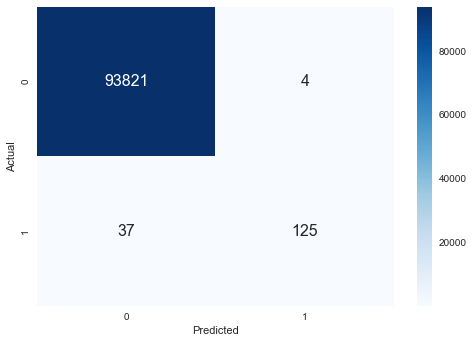

In [18]:
sns.heatmap(metrics.confusion_matrix(test[target],test['y_pred']),cmap='Blues',annot=True,fmt='d', annot_kws={'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

**After Autoencoding**

Train test split the encoded data

In [19]:
encoded_train,encoded_test = train_test_split(encoded_df,test_size=0.33,random_state=42,stratify=encoded_df[target])

train the classifier

In [20]:
%%time
enc_clf = xgb.XGBClassifier(objective='binary:logistic',use_label_encoder=False,eval_metric='logloss')
enc_clf.fit(encoded_train.drop([target],axis=1),encoded_train[target])

CPU times: user 3min 27s, sys: 1.74 s, total: 3min 29s
Wall time: 29.2 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

make predictions on the test data

In [21]:
encoded_test = encoded_test.copy()
encoded_test['y_pred'] = enc_clf.predict(encoded_test.drop([target],axis=1))

**Classification Report**

In [22]:
print(metrics.classification_report(encoded_test[target],encoded_test['y_pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.95      0.67      0.79       162

    accuracy                           1.00     93987
   macro avg       0.97      0.84      0.89     93987
weighted avg       1.00      1.00      1.00     93987



**Confusion Matrix**

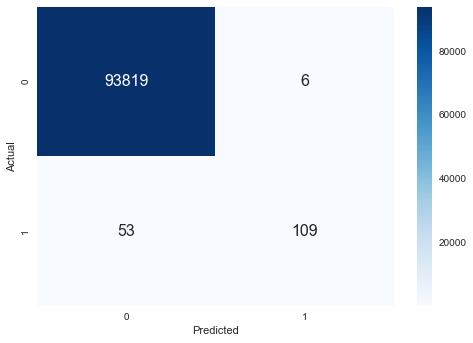

In [23]:
sns.heatmap(metrics.confusion_matrix(encoded_test[target],encoded_test['y_pred']),cmap='Blues',annot=True,fmt='d', annot_kws={'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

# Conclusions

- Here we have seen an example usage of the autoencoder architecture 
- Another aspect we can observe is the contrast between the orignal data vs encoded data through the xgboost model. In the same time the loss value from the autoencoder is playing a big role in the difference between the results from the both classifiers.
- The current data in this example is not illustrating the full potention of autoencoders since it has already being processed by PCA

# References

- [Semi Supervised Classification using AutoEncoders](https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders)
- [From Autoencoder to Beta-VAE](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#autoencoder)